In [3]:
import numpy as np, pandas as pd, scipy, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

# Import data
data_path = ('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')
df = pd.read_csv(data_path)

# Convert gender to numeric with one-hot encoding, drop irrelevant object columns
df = pd.concat([df, pd.get_dummies(df['gender'], drop_first=True)], 1)
df = df.drop(['name', 'bib',  'ctz', 'gender', 'city', 'state'], 1)

# Convert country to numeric with label encoder
num = LabelEncoder()
df['country'] = num.fit_transform(df['country'].astype('str'))

# Fill nan strings with mean value for the variable
for var in ['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k']:
    df[var] = pd.to_numeric(df[var], errors='coerce')
    df[var].fillna(df[var].mean(), inplace=True)

# Get info on column dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 16 columns):
10k          31984 non-null float64
division     31984 non-null int64
25k          31984 non-null float64
age          31984 non-null int64
official     31984 non-null float64
genderdiv    31984 non-null int64
35k          31984 non-null float64
overall      31984 non-null int64
pace         31984 non-null float64
30k          31984 non-null float64
5k           31984 non-null float64
half         31984 non-null float64
20k          31984 non-null float64
country      31984 non-null int64
40k          31984 non-null float64
M            31984 non-null uint8
dtypes: float64(10), int64(5), uint8(1)
memory usage: 3.7 MB


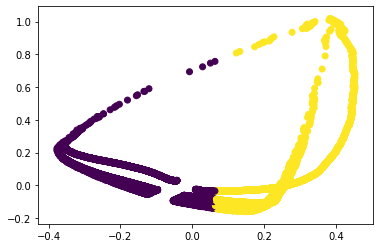

col_0      0     1
M                 
0      14333    34
1       8114  9503


In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X = df.drop('M', 1)
y = df['M']
X_norm = normalize(X)
X_pca = PCA(n_components=2).fit_transform(X_norm)

y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

print(pd.crosstab(y,y_pred))

Number of estimated clusters: 5


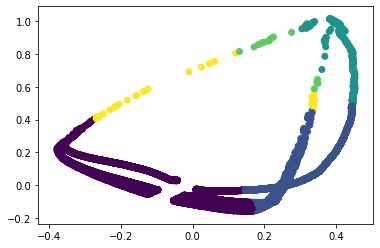

Comparing the assigned categories to the ones in the data:
col_0    0   1  2  3  4
age                    
18      25   7  1  0  0
19      27  13  1  0  0
20      84  25  2  0  0
21     127  42  4  0  0
22     210  64  6  0  0
..     ...  .. .. .. ..
77       7   0  0  0  0
78       5   0  0  0  0
79       3   0  0  0  0
80       3   0  0  0  0
81       6   0  0  0  0

[64 rows x 5 columns]


In [7]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X_pca, quantile=.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_pca)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y,labels))